Notes:

Model - 
lstm model (2 layers) using trigrams without word2vec, ran with 25 epochs

Data -
all taylor swift lyrics split in trigram sequences

Results -
decent! roughly 30% accuracy from both NN models
LSTM model takes forever (~5 mins each epoch) to run


In [1]:
import pandas as pd
import numpy as np
from nltk import word_tokenize, ngrams
import contractions
from keras.preprocessing.text import Tokenizer
import keras.utils.np_utils as ku
from keras.layers import Embedding, LSTM, Dense, Dropout
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras.preprocessing.sequence import pad_sequences
from gensim.models import Word2Vec, KeyedVectors
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
from collections import Counter

import matplotlib.pyplot as plt
import matplotlib.cm as cm

import random

In [2]:
# misc global vars
NGRAM_SIZE = 2 # note: we chose bigrams since the corpus is relatively small 
               # and higher-order ngrams are more often used for large (>1mil) corpora
LINE_START = '<s>'
LINE_END = '</s>'

# embedding size note: this can be changed to whatever
# we're using 100 to make the runtime less long
EMBEDDINGS_SIZE = 100

# data extraction stuff

In [3]:
def csv_to_lst(file):
    """
    Grabs the lyric section of the given csv and convert it to a string
    Parameters:
        file (CSV): file path where csv is located
    Returns:
        A list string representing all of the text section in the csv
    """
    lyrics_df = pd.read_csv(file) 
#     lyrics_df = lyrics_df

    lyrics_list = list(lyrics_df['lyrics'])


    return lyrics_list

In [4]:
def pre_process_all_lyrics(lyric_list):
    processed = []
    for lyrics in lyric_list:
#         print(lyrics)
        processed.append(pre_process_text(lyrics))
    return processed

In [5]:
def pre_process_line(line):
    EMBED = 'embed'
    word_list = word_tokenize(line)
    
   
    #index = word_list.index('Lyrics')
    #word_list = word_list[index + 1:]
    
    no_brackets_list = []
    is_inside = False
    punctuation_list = '''!()-[];:'"\,<>./?@#$%^&*_~”“’‘--...``'''''
    
    for word in word_list:
        if word == '[':
            is_inside = True
        if word == ']':
            is_inside = False
        else:
            if not is_inside:
                if word not in punctuation_list:
                    no_brackets_list.append(word.lower())

    if len(no_brackets_list) > 0:
        end_word = no_brackets_list[len(no_brackets_list)-1]   
        if EMBED in end_word:
#             print(end_word)
            embed_location = end_word.index('embed') 
            # all lyric genius data comes with word 'Embed' at the end
            substr = end_word[:embed_location]
            if len(substr) > 0:
                no_brackets_list[len(no_brackets_list)-1] = substr
        
        end_word = no_brackets_list[len(no_brackets_list)-1]  
        new_end_word = ''
        # also sometimes has a number before embed in last word
        for c in end_word:
            if c.isdigit():
                break
            else:
                new_end_word = new_end_word + c
        if len(end_word) > 0:
            no_brackets_list[len(no_brackets_list)-1] = new_end_word
       
    #note: we are doing this so that when we try to generate full song lyrics later, we have a marker to decide when
    # to move on to the next line
    ret = [LINE_START]
    for word in no_brackets_list:
        if len(word) < 0:
            break
        #idk why this is like this 
        elif word == "''":
            break
        else:
            ret.append(word)
            
    ret.append(LINE_END)
    return ret

In [6]:
def pre_process_text(lyrics):
    """
    Preprocesses the text to add start and end tokens to each sentence
    Parameters:
        lst (list): list of lyrics 
    Returns:
        List of List of words with start and end tokens
    """
    
    lyrics = contractions.fix(lyrics)
#     print(lyrics)
    line_list = lyrics.split("\n")
    line_list = line_list[1:] # removes the first line which contains meta info line artist name/song title etc
    
    ret = []
    for line in line_list:
        if not len(line) == 0:
            to_be_appended = pre_process_line(line)
            if len(to_be_appended) > 0:
                ret.append(to_be_appended)
    return ret

In [7]:
def flatten_songs(triple_list):
    """
    Optional: flattens list of [songs[lines[words]]] (3 deep) to just one
    long list of lines. This is used to make word vectors more smoothly
    Parameters:
        lst (list): list of lyrics 
    Returns:
        List of List of words with start and end tokens
    """
    long_list_lines = []
    for song in triple_list:
        for line in song:
            long_list_lines.append(line)
    return long_list_lines

In [8]:
lst = csv_to_lst('taylorswift.csv')
# print(lst)
all_songs = pre_process_all_lyrics(lst)
all_songs = flatten_songs(all_songs)

In [9]:
# for song in all_songs:
#     for line in song:
#         print(line)
print(all_songs[:50])

[['<s>', 'i', 'walked', 'through', 'the', 'door', 'with', 'you', 'the', 'air', 'was', 'cold', '</s>'], ['<s>', 'but', 'something', "'bout", 'it', 'felt', 'like', 'home', 'somehow', '</s>'], ['<s>', 'and', 'i', 'left', 'my', 'scarf', 'there', 'at', 'your', 'sister', "'s", 'house', '</s>'], ['<s>', 'and', 'you', 'have', 'still', 'got', 'it', 'in', 'your', 'drawer', 'even', 'now', '</s>'], ['<s>', '</s>'], ['<s>', 'oh', 'your', 'sweet', 'disposition', 'and', 'my', 'wide-eyed', 'gaze', '</s>'], ['<s>', 'we', 'are', 'singin', 'in', 'the', 'car', 'getting', 'lost', 'upstate', '</s>'], ['<s>', 'autumn', 'leaves', 'fallin', 'down', 'like', 'pieces', 'into', 'place', '</s>'], ['<s>', 'and', 'i', 'can', 'picture', 'it', 'after', 'all', 'these', 'days', '</s>'], ['<s>', '</s>'], ['<s>', 'and', 'i', 'know', 'it', 'is', 'long', 'gone', 'and', '</s>'], ['<s>', 'that', 'magic', "'s", 'not', 'here', 'no', 'more', '</s>'], ['<s>', 'and', 'i', 'might', 'be', 'okay', 'but', 'i', 'am', 'not', 'fine', 'at'

# word2vec

In [10]:
# pip install gensim

In [11]:
def train_word2vec(word_matrix):
    """
    Trains a Word2Vec model on the corpus provided
    Parameters:
        word_matrix: a list of list of string representing words in sentences in 
                    a larger corpus
                    eg:
                    [["<s>", "this", "is", "an", "example", "</s>"],
                     ["<s>", "this", "is", "also", "</s>"]
                    ]
    Returns:
        the trained Word2Vec model
    """
    model = Word2Vec(sentences=word_matrix, vector_size= EMBEDDINGS_SIZE, window=5,min_count=1)
    print('Vocab size {}'.format(len(model.wv.index_to_key)))
    return model

In [12]:
w2v_model = train_word2vec(all_songs)
word_vectors = w2v_model.wv

Vocab size 4887


Note: might be interesting to make some graphs on song content!

## data visualization segue

I was curious to see if there was any relation of lyrics between albums. 

In [13]:
# save as keyed vector for easy use
word_vectors.save('taylor_swift_wv.kv')

In [14]:
word_kv = KeyedVectors.load('taylor_swift_wv.kv')

print('50 most commonly words:')
print(word_kv.index_to_key[:50])

50 most commonly words:
['<s>', '</s>', 'i', 'you', 'the', 'and', 'to', 'is', 'it', 'me', 'not', 'a', 'my', 'in', 'that', 'are', 'your', 'do', 'of', 'we', 'all', 'am', 'but', 'on', 'will', 'was', 'be', 'know', 'like', 'have', 'this', 'oh', 'so', 'when', 'just', 'can', 'would', 'there', 'for', 'never', 'love', 'now', 'what', 'time', 'with', 'because', 'up', 'want', 'at', 'he']


### some global vars

In [15]:
graph_alpha = 0.7
n_similar_words = 30

In [16]:
def embedding_clusters(keys, kv, top_n_most_similar):
    embedding_clusters = []
    word_clusters = []
    for word in keys:
        embeddings = []
        words = []
        for similar_word, _ in kv.most_similar(word, topn=top_n_most_similar):
            words.append(similar_word)
            embeddings.append(kv[similar_word])
        embedding_clusters.append(embeddings)
        word_clusters.append(words)
    return (word_clusters, embedding_clusters)

In [17]:
def embeddings_en_2d(embedding_clusters):
    embedding_clusters_np = np.array(embedding_clusters)
    n, m, k = embedding_clusters_np.shape
    tsne_model_en_2d = TSNE(perplexity=15, n_components=2, init='pca', n_iter=3500, random_state=32)
    embeddings_en_2d = np.array(tsne_model_en_2d.fit_transform(embedding_clusters_np.reshape(n * m, k))).reshape(n, m, 2)
    return embeddings_en_2d

In [18]:
# plotting stuff 
def tsne_plot_similar_words(title, labels, embedding_clusters, word_clusters, a, filename=None):
    plt.figure(figsize=(16, 9))
    colors = cm.rainbow(np.linspace(0, 1, len(labels)))
    for label, embeddings, words, color in zip(labels, embedding_clusters, word_clusters, colors):
        x = embeddings[:, 0]
        y = embeddings[:, 1]
        plt.scatter(x, y, c=color, alpha=a, label=label)
        for i, word in enumerate(words):
            plt.annotate(word, alpha=0.5, xy=(x[i], y[i]), xytext=(5, 2),
                         textcoords='offset points', ha='right', va='bottom', size=8)
    plt.legend(loc=4)
    plt.title(title)
    plt.grid(True)
    if filename:
        plt.savefig(filename, format='png', dpi=150, bbox_inches='tight')
    plt.show()

In [19]:
def plot_similarities(title, labels, kv, n_similar_words, a, filename):
    '''plots similar words to the given labels
    Parameters:
    title -- title of the graph
    labels -- list of words to find similar words to
    kv -- keyed vectors to use aka whole dataset
    n_similar_words -- number of similar words to find
    a -- alpha value for graph
    filename -- what to save the file as
    '''
    
    cluster = embedding_clusters(labels, kv, n_similar_words)
    en_2d = embeddings_en_2d(cluster[1])
    
    tsne_plot_similar_words(title, labels, en_2d, cluster[0], a, filename)

### by album name

In [20]:
# not an exhaustive list, just the main ones
# tragically speak now had to split into two words, which is prob not great for accuracy
album_titles = ['speak', 'now', 'fearless', 
                'red', '1989', 'reputation', 
                'lover', 'folklore', 'evermore']

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

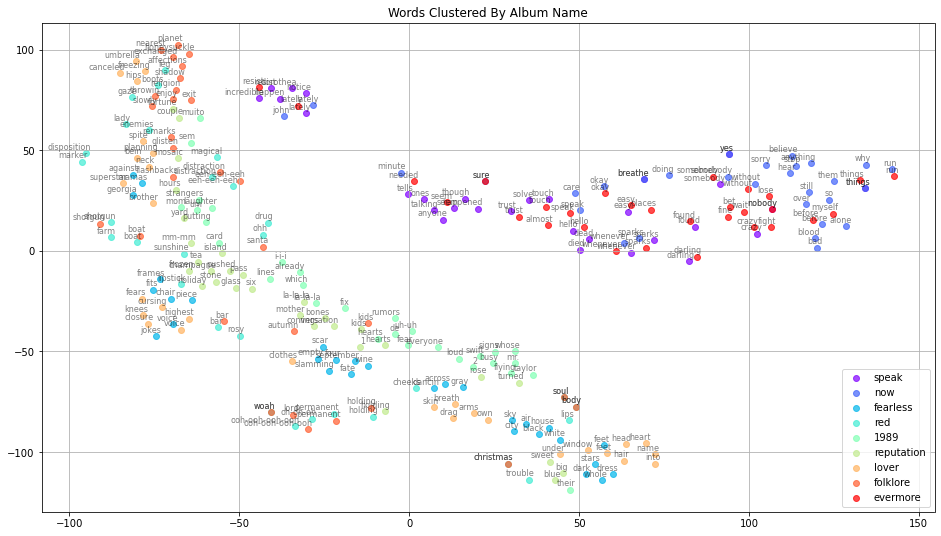

In [21]:
plot_similarities('Words Clustered By Album Name',
                 album_titles,
                 word_kv,
                 n_similar_words,
                 graph_alpha,
                 'taylor_swift_words_cluster_by_album.png')

Not as clustered as I'd hoped :( but also not unclustered :)

### by pronoun

was also interested in pronouns

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

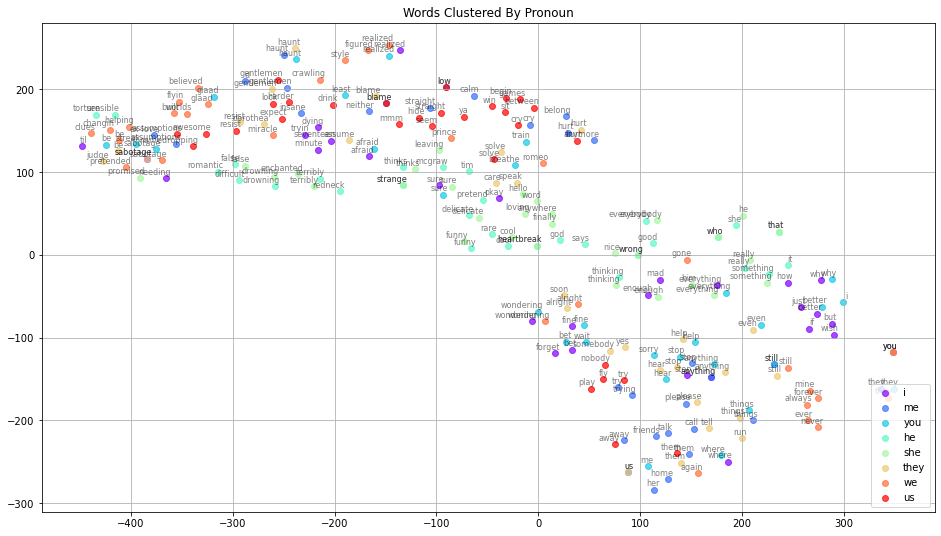

In [22]:
pronouns = ['i', 'me', 'you', 'he', 'she', 'they', 'we', 'us']

plot_similarities('Words Clustered By Pronoun',
                 pronouns,
                 word_kv,
                 n_similar_words,
                 graph_alpha,
                 'taylor_swift_words_cluster_by_pronoun.png')

### by posessive pronoun

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

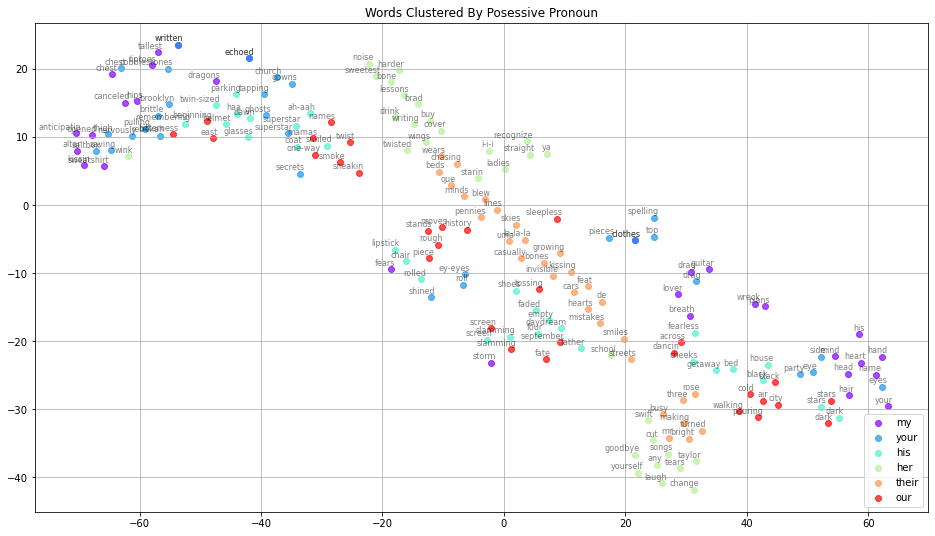

In [23]:
posessive_pronouns = ['my', 'your', 'his', 'her', 'their', 'our']

plot_similarities('Words Clustered By Posessive Pronoun',
                 posessive_pronouns,
                 word_kv,
                 n_similar_words,
                 graph_alpha,
                 'taylor_swift_words_cluster_by_posessive_pronoun.png')

# generating training samples

In [24]:
tokenizer = Tokenizer()

tokenizer.fit_on_texts(all_songs)
sequences = tokenizer.texts_to_sequences(all_songs)
# print(flatten_genre[0:10])
# print(word_embeddings[0:10])
print('corpus len: ', len(sequences))
# to_categorical needs this idk why
# vocab_size = len(tokenizer.word_index) + 1
# print('vocab size: ', vocab_size)

corpus len:  25867


### split into ngrams

In [25]:
def generate_ngram_training_samples(word_embeddings, n) -> list:
    '''
    Takes the encoded data (list of lists) and 
    generates the training samples out of it.
    Parameters:
    word embeddigns = list
    n = size of n gram
    return: 
    list of lists in the format [[x1, x2, ... , x(n-1), y], ...]
    '''
    full_list = []
    for we in word_embeddings:
        full_list.extend(we)
    ngram_list_tup = ngrams(full_list, n)
    ngram_list = []
    for tup in ngram_list_tup:
        as_list = list(tup)
        ngram_list.append(as_list)
    return ngram_list

In [26]:
ngrams_list = generate_ngram_training_samples(sequences, NGRAM_SIZE)
print(ngrams_list[:10])
print('num ngrams: ', len(ngrams_list))
# print(ngrams_list)

[[1, 3], [3, 357], [357, 109], [109, 5], [5, 186], [186, 45], [45, 4], [4, 5], [5, 460], [460, 26]]
num ngrams:  221790


In [27]:
def get_X_y(ngrams_list):
    '''
    Splits n-grams into X predictor matrix and associated y label vector
    Parameters:
    ngrams_list = list of ngrams in form of [[0, 1, 2], ....]
    return: 
    tuple (X, y)
    '''
    X = []
    y = []
    # splits ngrams into [a, b], [c]
    for ng in ngrams_list:
        x = []
        for i in range(0, len(ng)):
            if i < len(ng) - 1:
                #predictor
                x.append(ng[i])
            else:
                #label
                y.append(ng[i])
        X.append(x)
    # note both need to be np.arrays to work with model
    return (np.array(X), np.array(y))

In [28]:
X_pred, y_label = get_X_y(ngrams_list)

# spot check for correctness
# for i in range(0, 10):
#     print(X_pred[i], y_label[i])
print('X shape: ', X_pred.shape)
print('y shape: ', y_label.shape)

print('y indexed at ?')
copy = np.sort(y_label.copy())
print(type(copy))
print(copy[:10])
print(copy[len(copy)-10:])

X shape:  (221790, 1)
y shape:  (221790,)
y indexed at ?
<class 'numpy.ndarray'>
[1 1 1 1 1 1 1 1 1 1]
[4878 4879 4880 4881 4882 4883 4884 4885 4886 4887]


In [29]:
def map_sequences_to_embeddings(word_vectors, tokenizer):
    '''maps word's sequence to word's embedding
    Parameters:
        word_vectors word vector list from word2vec
        tokenizer the tokenizer trained on the corpus
    Returns:
        dict mapping the word's sequence (from tokenizer) to it's embedding
    '''
    seq_to_embedding = dict()
    for word in word_vectors.index_to_key:
        embedding = word_vectors[word]
        seq = tokenizer.word_index[word]
        seq_to_embedding[seq] = embedding
    
    print('seq to embeddings map size: ', len(seq_to_embedding.keys()))
    
    return seq_to_embedding

In [30]:
seq_to_embedding_map = map_sequences_to_embeddings(word_vectors, tokenizer)
vocab_size = len(seq_to_embedding_map.keys())

seq to embeddings map size:  4887


### change bigrams to embeddings for model

In [31]:
def to_embeddings(X: list, y: list, sequence_embeddings: dict) -> (list,list):
    '''
    turns X sequences and y sequences to embeddings
    Parameters:
        X - list of ngram sequences that are the predictors
        y - list of sequences that are the associated labels
        sequence_embeddings - maps sequences to w2v embeddings
    Returns:
        a tuple of (X_as_embeddings, y_as_embeddings)
    '''
    vocab_size = len(sequence_embeddings.keys())
    
    if len(X) != len(y):
        print('error: something went wrong here -- X should be same len as y')
    
    X_embeddings = []
    for ngram in X:
        embedding = []
        for gram in ngram:
            embedding.extend(sequence_embeddings[gram])
        X_embeddings.append(embedding)
    
    # use to_categorial to get one_hots
    y_categorical_labels = ku.to_categorical(y) 
    
    return (np.array(X_embeddings), y_categorical_labels)

In [32]:
# pred and label initial inputs
X_embedding_matrix, y_categorical_label = to_embeddings(X_pred,
                                                         y_label,
                                                         seq_to_embedding_map)

# spot check
print('x embeddings shape: ', X_embedding_matrix.shape)
print('y label shape: ', y_categorical_label.shape)

x embeddings shape:  (221790, 100)
y label shape:  (221790, 4888)


In [33]:
print(len(y_categorical_label[0]))

4888


In [34]:
print(len(X_embedding_matrix[0]))

100


# Create Models

### Baseline Statistical Model - Bigram Bag of Words
We're doing this to see if using a Neural Network at all is overkill, since this corpus is relatively small. Code is adapted from HW2. Uses the raw bigrams as opposed to embeddings and also applies laplace smoothing

In [35]:
class Bigram_BOW_Model:
    def __init__(self, tokenizer, sequences):
        training_data, testing_data = self.split_dataset(sequences)
        training_bigrams = generate_ngram_training_samples(training_data, 2)
        testing_bigrams = generate_ngram_training_samples(testing_data, 2)
        
        self.vocab_size = len(tokenizer.word_index) + 1
    
        print(training_bigrams[:10])
        bigram_matrix = self.bigram2matrix(training_bigrams)
        
        flattened = np.concatenate(sequences)
#         print(flattened)
        word2count = Counter(flattened)
        self.word2probability = self.calc_probability(bigram_matrix, 
                                                          word2count)
        self.accuracy = self.test_accuracy(testing_bigrams)
        
        self.summary()
#         print(bigram_matrix.shape)
#         print(self.word2probability.shape)
#         print(len(word2count))
#         print(word2count)
        pass
    
    def split_dataset(self, sequences):
        '''
        reserves a random subset of the corpus for testing purposes. subset reserved is 10%
        '''
        print('start ',len(sequences))
        n_reserve = int(0.1 * len(sequences))
        reserve = []
        for _ in range(1, n_reserve):
            rand = random.randint(0, len(sequences) - 1)
            test_datum = sequences[rand]
            reserve.append(test_datum)
            del(sequences[rand])
        
#         print('end ', len(sequences))
#         print(len(reserve))
#         print(reserve)
        return (sequences, reserve)
    
    def bigram2matrix(self, bigrams):
        ''' creates a vocab_size*vocab_size matrix that counts the number
        of times that a sequence appears after another sequence in the list
        of ngrams
        '''
        M = np.zeros(shape=(self.vocab_size, self.vocab_size))
        for pair in bigrams:
#             print(pair)
            w1 = pair[0]
            w2 = pair[1]
            M[w1][w2] += 1.0
        return M

    def calc_probability(self, bigram_matrix, word2count):
        ''' creates a vocab_size*vocab_size matrix that tells the probability that
        row sequence will be followed by col sequence.
        '''   
        print('bigram m ', bigram_matrix.shape)
        print('unigram m ', len(word2count))
        M = np.zeros(shape=(self.vocab_size, self.vocab_size))
        for row in range(1, self.vocab_size):
            for col in range(1, self.vocab_size):
                M[row][col] = bigram_matrix[row][col] / (word2count[row])
#                 print(M[row][col])
#             print(np.sum(M[row]))
        return M
    
    def test_accuracy(self, testing_bigrams):
        ''' tests the given gold-label test set against what the model predicts
        '''
        correct_count = 0
        
        for datum in testing_bigrams:
            pred = datum[0]
            label = datum[1]
            
            pdistr = self.predict(pred)[0]
            choice = np.argmax(pdistr)
            if choice == label:
                correct_count += 1
        return float(correct_count) / float(len(testing_bigrams))
    
    def predict(self, seed):
        ''' returns probability matrix of the given seed sequence
        '''
        return [self.word2probability[seed]]
    
    def summary(self):
        print("------------------------------")
        print("BIGRAM BOW STATISTICAL MODEL:")
        print("------------------------------")
        print("accuracy: ", self.accuracy)
        print("------------------------------")

In [36]:
# print(ngrams_list[:10])
# print(sequences)
bow_model = Bigram_BOW_Model(tokenizer, sequences)

start  25867
[[1, 3], [3, 357], [357, 109], [109, 5], [5, 186], [186, 45], [45, 4], [4, 5], [5, 460], [460, 26]]
bigram m  (4888, 4888)
unigram m  4744


/var/folders/92/hkn2b2hd6vlf9bf_51zhtkkc0000gn/T/ipykernel_45209/2671199780.py:66: RuntimeWarning: invalid value encountered in double_scalars
  M[row][col] = bigram_matrix[row][col] / (word2count[row])


------------------------------
BIGRAM BOW STATISTICAL MODEL:
------------------------------
accuracy:  0.3369511371312767
------------------------------


### Feed-Forward Neural Network
2-layer model with 150 hidden units per each layer

In [37]:
def create_FF_model(pred,
                 label,
                 hidden_units,
                 vocab_size, 
                 num_epochs):
    '''
    Creates a model using a 2-layer Feedforward neural network
    '''
    model = Sequential()
    model.add(Dense(units=hidden_units, 
                    activation='relu', 
                    input_dim=pred.shape[1]))
#     model.add(Dense(units=hidden_units, 
#                     activation='relu', 
#                     input_dim=pred.shape[1]))
    
    # output layer
    model.add(Dense(units=vocab_size, 
                    activation='softmax'))
    
    # compile and fit
    model.compile(loss='categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])
    
    model.fit(x=pred, 
                     y=label,
                     epochs=num_epochs)
    print(model.summary())
    
    return model

### LSTM Neural Network
2-layer model with 50 hidden units per each layer (this is less than the feed-forward network because we found it doesn't really help to have more and also takes forever to train.

In [38]:
def create_LSTM_model(pred,
                     label,
                     hidden_units,
                     vocab_size,
                     num_epochs):
    '''
    Creates a model using a 2-layer LSTM neural network
    note: 50 hidden units for each layer
    '''
    #lstm expects input in the shape of (# samples, #timesteps, #features)
    # we're using one feature per input 
#     pred = pred.reshape((pred.shape[0], pred.shape[1], 1))
    
    model = Sequential()
    
    model.add(LSTM(hidden_units, 
                   activation='relu',
                   input_shape=(pred.shape[1], 1),
#                    return_sequences=True
                  ))
#     model.add(LSTM(50, 
#                    activation='relu'
#                   ))
    
    # output layer
    model.add(Dense(units=vocab_size, 
                    activation='softmax'))
    
    # compile and fit
    model.compile(loss='categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])
    model.fit(x=pred, 
                     y=label,
                     epochs=num_epochs)
    
    print(model.summary())
    return model

In [39]:
#spot check
print(X_embedding_matrix.shape)
print(X_embedding_matrix[0].shape)
print(X_embedding_matrix.shape[1])
print(len(X_embedding_matrix[0]))

(221790, 100)
(100,)
100
100


In [40]:
hidden_units = 150
# plateaus after this
num_epochs = 50
ff_model = create_FF_model(X_embedding_matrix,
                           y_categorical_label,
                           hidden_units,
                           vocab_size + 1,
                           num_epochs)

Epoch 1/50


2022-05-03 22:58:44.936194: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


6931/6931 [==============================] - 34s 5ms/step - loss: 4.1625 - accuracy: 0.2865
Epoch 2/50
6931/6931 [==============================] - 34s 5ms/step - loss: 3.7685 - accuracy: 0.2967
Epoch 3/50
6931/6931 [==============================] - 35s 5ms/step - loss: 3.6612 - accuracy: 0.2988
Epoch 4/50
6931/6931 [==============================] - 35s 5ms/step - loss: 3.6033 - accuracy: 0.3007
Epoch 5/50
6931/6931 [==============================] - 35s 5ms/step - loss: 3.5629 - accuracy: 0.3019
Epoch 6/50
6931/6931 [==============================] - 35s 5ms/step - loss: 3.5332 - accuracy: 0.3033
Epoch 7/50
6931/6931 [==============================] - 35s 5ms/step - loss: 3.5081 - accuracy: 0.3049
Epoch 8/50
6931/6931 [==============================] - 35s 5ms/step - loss: 3.4879 - accuracy: 0.3056
Epoch 9/50
6931/6931 [==============================] - 35s 5ms/step - loss: 3.4698 - accuracy: 0.3068
Epoch 10/50
6931/6931 [==============================] - 36s 5ms/step - loss: 3.4549

In [43]:
# kinda plateau's after that
hidden_units = 50
num_epochs = 5
lstm_model = create_LSTM_model(X_embedding_matrix,
                            y_categorical_label,
                            hidden_units,
                            vocab_size + 1,
                            num_epochs)

Epoch 1/5
6931/6931 [==============================] - 166s 24ms/step - loss: 5.3782 - accuracy: 0.1561
Epoch 2/5
6931/6931 [==============================] - 164s 24ms/step - loss: 4.7116 - accuracy: 0.2254
Epoch 3/5
6931/6931 [==============================] - 165s 24ms/step - loss: 4.7770 - accuracy: 0.2152
Epoch 4/5
6931/6931 [==============================] - 165s 24ms/step - loss: 25847.4512 - accuracy: 0.2316
Epoch 5/5
6931/6931 [==============================] - 165s 24ms/step - loss: 4.4847 - accuracy: 0.2514
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 50)                10400     
                                                                 
 dense_4 (Dense)             (None, 4888)              249288    
                                                                 
Total params: 259,688
Trainable params: 259,688
Non-traina

# generate lyrics

In [44]:
def get_seed_embeddings(sequence_list, seq_to_embeddings_map, ngram_size):
    '''from the list of seed sequences, maps them to their embeddings. 
    ensures that the embedding is ngram len.
    NOTE: if there is no embedding for the given sequence, it will just return something random
    '''
    pred_size = ngram_size - 1
    if len(sequence_list) > pred_size:
        sequence_list = sequence_list[len(sequence_list) - pred_size:]
    embedding_list = []
    for seq in sequence_list:
        embedding_list.extend(seq_to_embeddings_map[seq])

    return np.array(embedding_list)
            

In [45]:
def generate_text(tokenizer, 
                  model, 
                  seq_to_embedding_map, 
                  seed_text, 
                  num_lines_to_generate, 
                  ngram_size, 
                  isNN
                 ):
    words = []
    # start off return set of words with the seed
    words.extend(seed_text.split())
    lines_generated_counter = 0
    
    while lines_generated_counter < num_lines_to_generate:
        token_list = tokenizer.texts_to_sequences([seed_text])[0]
        if len(token_list) == 0:
            # invalid seed/seed doesn't exist in corpus -- choose a random one
            random_seq = np.random.choice(np.arange(1, len(seq_to_embedding_map.keys())))
            token_list = [random_seq]
        
        embeddings = get_seed_embeddings(token_list, seq_to_embedding_map, ngram_size)
        
        #basically are we using embeddings or not -- both NNs do, BOW doesn't
        if isNN:
            predicted = model.predict(np.reshape(embeddings, (-1, embeddings.shape[0])), verbose=0)
        else:
            predicted = model.predict(token_list[0])
            

        # ways of getting the top choice -- any are fine but we like np.random.choice the best
        
#         choice = np.argmax(predicted)
        choice = np.random.choice(len(predicted[0]), p=predicted[0]) 
#         choice = sample(predicted[0])

        word = tokenizer.index_word[choice]
        
        # so we stop eventually
        if word == LINE_END:
            lines_generated_counter += 1
        
        words.append(word)
        seed_text = word # this is fine because we're running a bigram
        
    return format_lyrics(words)

In [46]:
# SOURCE: [TODO: fill in]
def sample(preds, temperature=1):
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

In [51]:
def format_lyrics(words):
    lyr = ""
    # for testing
#     print(words)
#     print('----------')
    for word in words:
        if word == LINE_END:
            # replace with newline char
            lyr = lyr + "\n"
        else: 
            # add lyric
            if word != LINE_START:
                lyr = lyr + " " + word
    return lyr

# Compare Results
Compares the resulting lyrics generated by each model using the same seed

In [48]:
def generate_lyrics(seed, 
                             useBOW, 
                             useFF, 
                             useLSTM, 
                             n_lines):
    '''Generates lyrics using the same seed and same number of lines for each model.
    Parameters:
    useBOW -- boolean flag for if we should use BOW model
    useFF -- boolean flag for if we should use FF model
    useLSTM -- boolean flag for if we should use LSTM model
    seed -- seed text i.e.: 'i'
    n_lines -- number of lines to generate
    
    '''
    print('+++++++++++++++++++++++++++++++++++++++++++++++++')
    print('Seed: ', seed)
    print('Num. Lines: ', n_lines)
    print('+++++++++++++++++++++++++++++++++++++++++++++++++')
    
    if useBOW:
        lyrics = generate_text(tokenizer, 
                          bow_model,
                          seq_to_embedding_map,
                          seed, 
                          n_lines, 
                          NGRAM_SIZE,
                          False)
        print('==============================================')
        print('Model Info: Laplace-Smoothed Bigram BOW Statistical Model')
        print('----------------------')
        print(lyrics)
        print('==============================================')
    
    if useFF:
        lyrics = generate_text(tokenizer, 
                          ff_model,
                          seq_to_embedding_map,
                          seed, 
                          n_lines, 
                          NGRAM_SIZE,
                          True)
        print('==============================================')
        print('Model Info: Feed-Forward Neural Network')
        print('----------------------')
        print(lyrics)
        print('==============================================')
    if useLSTM:
        lyrics = generate_text(tokenizer, 
                          lstm_model,
                          seq_to_embedding_map,
                          seed, 
                          n_lines, 
                          NGRAM_SIZE,
                          True)
        print('==============================================')
        print('Model Info: LSTM Neural Network')
        print('----------------------')
        print(lyrics)
        print('==============================================')
    
    print('Done.')

# Finally, some lyrics!

In [55]:
lines_to_generate = 50

In [56]:
generate_lyrics('you are', True, True, True, lines_to_generate)

+++++++++++++++++++++++++++++++++++++++++++++++++
Seed:  you are
Num. Lines:  50
+++++++++++++++++++++++++++++++++++++++++++++++++
Model Info: Laplace-Smoothed Bigram BOW Statistical Model
----------------------
 you are fall
 got tired of what a willow and it
 too late to hurt anymore
 too long time this entire night in an arrow head
 a rest of cool that will be alone
 too
 a distant diamond sky
 eve
 over you
 a month of your first
 a shame on sidewalks
 too busy dancing with her arms that letting go out of you need a beautiful beautiful smile black and now we had to break what you waiting for the way you in front of you gave you
 eve
 got a daze pull me i would swear i would dance first swing i wanted
 a better man who might have absolutely loved you
 a life i know you gave you
 too
 eve
 too
 killing you are the rain
 got to call my hand
 eve
 over your room
 killing you so oh-oh and everybody 's farm
 a bar
 got that is jingleball there are the man
 got my
 got you are not want
 a

In [57]:
generate_lyrics('i am', True, True, True, lines_to_generate)

+++++++++++++++++++++++++++++++++++++++++++++++++
Seed:  i am
Num. Lines:  50
+++++++++++++++++++++++++++++++++++++++++++++++++
Model Info: Laplace-Smoothed Bigram BOW Statistical Model
----------------------
 i am would say you are again when it
 over the 28th night
 got a revolution the trees change my heart
 a love
 eve
 a bad
 over and let it off i want to be your past his daddy let us to you on your nights when you can not know if i am concerned you kissed me in a girl in my eclipsed sun goes so terrified of you are ever been you all i will remember it cool that it is not together
 eve
 a failure
 too well
 over your queen
 a nice that flashed before i do not a time i met the ground
 got an explanation
 eve
 too well i woke up last train could be here in your eyes
 eve
 got a figment of the high heels on the best dress
 got a roller coaster kind of view
 eve
 got some miracle
 killing you for that i say
 a little stars fall down trying to be something bad habits
 a record changer


In [58]:
generate_lyrics('this is', True, True, True, lines_to_generate)

+++++++++++++++++++++++++++++++++++++++++++++++++
Seed:  this is
Num. Lines:  50
+++++++++++++++++++++++++++++++++++++++++++++++++
Model Info: Laplace-Smoothed Bigram BOW Statistical Model
----------------------
 this is is life if i can see me oh what to be crawling up to lose you as you all i am holding on a sunday matinée
 a very last time
 killing it was a long live all her
 eve
 killing me out of your mama 's smart
 eve
 a redneck heartbreak time i shake their babies on a party
 got it killing me again
 got to me in the party
 killing me out
 a letter left when you could follow follow
 killing you got a little
 over again i got enough for once revolved around for
 killing me how it love hangs around
 got to breaking
 a big parties were never met me you stray i said forever hold on do not need you will not around and never wanted
 a minute now
 got that
 too
 got a fiend in your best four years of us lost time
 a fire jumping in front of cold
 killing it works
 too well
 a loaded g

In [59]:
generate_lyrics('his', True, True, True, lines_to_generate)

+++++++++++++++++++++++++++++++++++++++++++++++++
Seed:  his
Num. Lines:  50
+++++++++++++++++++++++++++++++++++++++++++++++++
Model Info: Laplace-Smoothed Bigram BOW Statistical Model
----------------------
 his house is supposed to a work of it cool kids
 a careless man
 a distant memory 'll
 a feeling
 a cowboy like that night is long
 over
 killing me i thought you
 got a lot like you break a wine-stained
 eve
 eve
 too well
 eve
 killing you standing in loving you find something to leave me oh-oh oh oh i do not want and i know who is hard or just for every time
 over things that is pouring rain
 a while since yesterday i do
 eve
 eve
 too much for me for us go
 got his head i never want to you walk me
 a thug story baby no
 got it will be something
 got pushed aside
 killing me padding across the lie and i should have been the best mates
 got love it all
 a getaway car
 got lost again but you need to shake it be waiting for my heart is a cloudy day holds too many saying i love sto

In [60]:
generate_lyrics('my', True, True, True, lines_to_generate)

+++++++++++++++++++++++++++++++++++++++++++++++++
Seed:  my
Num. Lines:  50
+++++++++++++++++++++++++++++++++++++++++++++++++
Model Info: Laplace-Smoothed Bigram BOW Statistical Model
----------------------
 my guitar
 killing me
 killing me
 too much i do not easy
 killing it off
 got enough
 eve
 killing me where i hope of it all gone home 'fore i
 killing me you are tired of you changed
 a friend
 got are gone all we are not spell awesome
 a little girl that
 a fairytale
 over mm
 a baller
 over and somebody
 too soon as long
 over
 eve
 a field
 a motel bar
 a dazzling haze a bad feeling sinks in with me up as many things that i
 a while oh why it takes one here
 too late
 too late
 a right now i defending now you say never be
 killing you
 too hard not dream
 killing me alive but whenever you and all around saying
 a simple name
 too far enough
 too far above me alone
 a tough but i have gone
 a sad beautiful beautiful magic 's toys
 a boating license when you got his car
 a psych

In [61]:
generate_lyrics('her', True, True, True, lines_to_generate)

+++++++++++++++++++++++++++++++++++++++++++++++++
Seed:  her
Num. Lines:  50
+++++++++++++++++++++++++++++++++++++++++++++++++
Model Info: Laplace-Smoothed Bigram BOW Statistical Model
----------------------
 her fault
 killing me swallowin my friends are never mine
 eve
 eve
 over baby
 a lot of you in red
 a showdown showdown
 got a look like me that do not reading what do not know
 got the refrigerator light
 over me and you will not superficial
 a man
 a miracle was one more than fight it is kind of how we found us apart
 over and i will never knew my reflection for the only thing was fading
 killing you can withstand
 a million little town
 eve
 got bad feeling so many signs
 too tired me holding my hand three months in the back in the one of his briefcase and there by the faded blue jeans and you would just want to me out
 a really had when
 too much older too young when you need you spin around to take you lift my room for the kind
 killing me now we are the more than
 eve
 a to

In [ ]:
# add more here